# DS3000 Lecture 19

### Admin:
- Homework 10 and 11 for this week
- Quiz 3 for this weekend
- Second to the last week! Check your grade before the end of the semester
- Project template is posted last week
- Will send out an announcement to select presentation slot later today. 
- Following week:
    - Aug 12th, Geospatial data
    - Aug 13th, Project day
    - Aug 14th, Presentation (required)
    - Aug 15th, Project day
    - Aug 19th, Project final report and extra credit are due
- TRACE evaluation is out!

### Content:
- Decision Trees and Random Forests

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Decision Trees

A **decision tree** is a flowchart (directed binary tree) where each node partitions samples via a single feature. Let's learn by doing:

In [8]:
import seaborn as sns
from sklearn import tree
import matplotlib.pyplot as plt

# read in the final, clean data set (reset so we no longer have the standardized columns)
df_gtky = pd.read_csv('final_gtky.csv', index_col='student_id')
df_gtky.dropna(how='any', inplace=True)
df_gtky.head()

# we can represent a binary categorical variable in a single indicator tag (as in our co-op example)
# let's do that with sophomores, juniors, and seniors (5th years and others we'll leave alone)
df_gtky['is_sop'] = df_gtky['class'] == 'Sophomore'
df_gtky['is_jun'] = df_gtky['class'] == 'Junior'
df_gtky['is_sen'] = df_gtky['class'] == 'Senior'

# discard any rows missing data
df_gtky.dropna(axis=0, inplace=True)

In [9]:
df_gtky.head()

,class,co-op,prog_exp,age,start_sal,datetimestamp,python,java,r,c/c++,other(s),is_sop,is_jun,is_sen
student_id,,,,,,,,,,,,,,
740492,Sophomore,False,9,234.0,60.0,2022-09-09 15:37:00,True,False,False,False,True,True,False,False
20d026,Sophomore,False,7,233.0,100.0,2022-09-09 16:01:00,True,False,False,False,False,True,False,False
e7fc49,Junior,True,7,252.0,70.0,2022-09-09 14:19:00,True,True,False,True,False,False,True,False
a49897,Junior,False,7,243.0,50.0,2022-09-09 16:07:00,True,True,False,False,False,False,True,False
425374,Sophomore,False,5,231.0,90.0,2022-09-09 16:06:00,True,False,True,False,False,True,False,False


## Who had Python experience coming into this class/can we predict if a student does?

Our y-feature is now `python`, all others can (and will) be used as x-features (except for datetimestamp)

In [10]:
def train_dec_tree_gtky(df_gtky, max_depth=3, x_feat_list=None, plot=True):
    """ trains a decision tree classifier, optionally prints graph
    
    Args:
        df_gtky (pd.DataFrame): ds3000 students
        max_depth (int): max depth of decision tree
        x_feat_list (list): list of input features
        plot (bool): toggles graph output (default: True)
        
    Returns:
        dec_tree_clf (DecisionTreeClassifier): trained
            decicision tree
    """
    
    if x_feat_list is None:
        # default x feature list
        # (a list is mutable, if we set the default to this list then it can
        # be modified with distinct calls to the function so that default behavior
        # changes over time ... its common to use None as a default and have these 
        # little if statements to set such a default within the function body)
        x_feat_list = ['co-op', 'prog_exp', 'age', 'start_sal', 'java', 'r', 'c/c++', 'other(s)', 'is_sop', 'is_jun', 'is_sen']

    # extract data from dataframe
    x = df_gtky.loc[:, x_feat_list].values
    y = df_gtky.loc[:, 'python'].values
    
    # build decision tree classifier
    dec_tree_clf = tree.DecisionTreeClassifier(max_depth=max_depth)

    # fit data
    dec_tree_clf = dec_tree_clf.fit(x, y)
    
    # plot figure of decision tree
    if plot:
        # initialize empty figure (plot_tree sets text size to fill given figure
        # if we resize figure afterwards text size remains too small)
        plt.figure()
        plt.gcf().set_size_inches(15, 10)
        
        # 'plot' decision tree
        tree.plot_tree(dec_tree_clf, 
                       feature_names=x_feat_list)
    
    return dec_tree_clf

In [12]:
# how many did / didn't have python experience in our dataframe?
df_gtky['python'].value_counts()

python
True     80
False    20
Name: count, dtype: int64

# Super Important Sci-kit Learn Convention: 

- leftward branches are 'yes'
- rightward branches are 'no'

**What do we mean by 'branches'?**

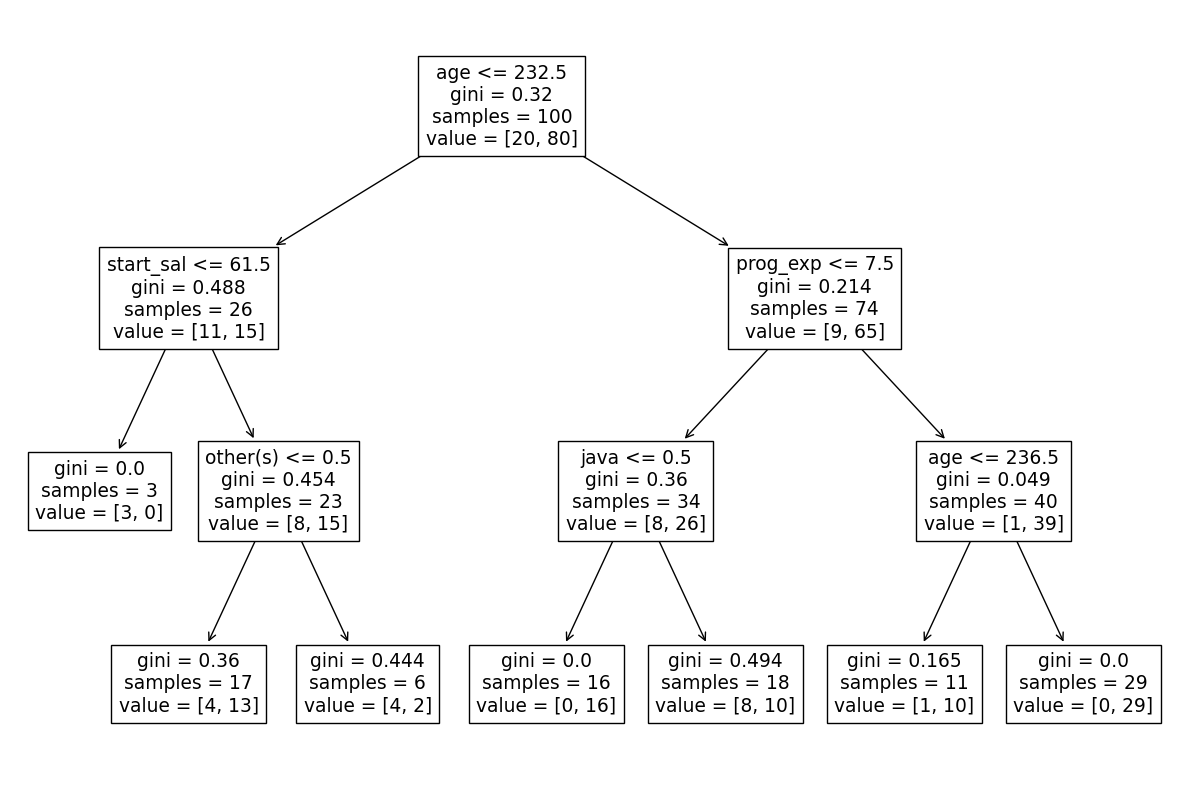

In [11]:
dec_tree = train_dec_tree_gtky(df_gtky, max_depth=3, plot=True)

### Questions

1. How do we learn the order of variables in the tree?
    - ie. why `age` as the root note above? why do only some features show up and not others?
1. How do we learn the threshold at each particular node?
1. We stop at a `max_depth=3` here (for pedagogical reasons), but what depth should be used in general?
1. What is `gini`???

 <img src="https://www.thelist.com/img/gallery/this-is-what-happened-to-the-girl-who-played-ginny-weasley-in-harry-potter/intro-1565807949.jpg" alt="title" >

## Gini Impurity Index

Given  $J$  classes, for  $i ∈{1,2,...,J}$ and let $p_i$ be the fraction of items of class  $i$. Then the GINI index is defined as:

$$ \texttt{Gini}(p) = 1 - \sum_i p_i ^2 $$

Less Formally:
If I just guess* what is the probability that I'm going to be incorrect? (Another way of phrasing: total probability of being incorrect by guessing).

*Guessing is done per the distribution. Without considering any features, in the python experience example
- we guess has experience 80% of the time
- we guess has no experience 20% of the time

because:

In [13]:
df_gtky['python'].value_counts()

python
True     80
False    20
Name: count, dtype: int64

In [15]:
#0: False class, 1: True class
p0 = 20/100

In [16]:
p1 = 80/100

We are incorrect in two situations:

1. A student who has python experience ($p_1=.8$) is guessed as having no python experience ($p_0=.2$); probability $= p_1p_0 = .8\times.2 = .16$
2. A student who has no python experience ($p_0=.2$) is guess as having python experience ($p_1=.8$); probability $= p_0p_1 = .2\times.8 = .16$

So that we may compute our initial Gini Impurity Index (total prob of being incorrect by guessing) for a binary distribution, as:

$$\begin{align}
\texttt{Gini}(p)
&= p_0p_1 + p_1p_0\\
&= p_0 (1 - p_0) + p_1 (1 - p_1)
\end{align}
$$

So that the probability of being incorrect by just guessing ("Gini Impurity"):

In [17]:
gini = p0*(1-p0) + p1*(1-p1)
gini

0.32

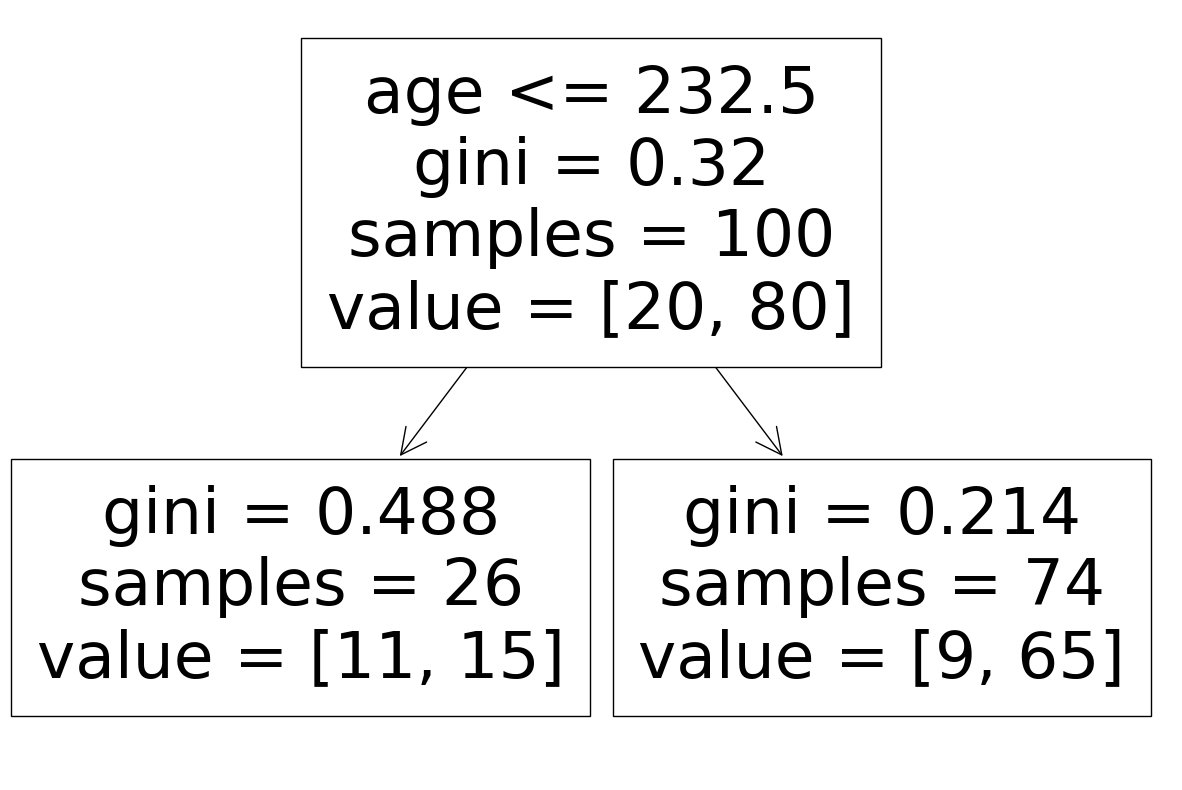

In [18]:
# see it again
dec_tree = train_dec_tree_gtky(df_gtky, max_depth=1, plot=True)

In [19]:
p0 = 11/26
p1 = 15/26
p0*(1-p0) + p1*(1-p1)

0.4881656804733727

Intuition:
- high Gini impurity value
    - samples belong to many classes
    - this is not desired
        - ... our classification is not yet done
- low Gini impurity value
    - all samples belong to a single class
    - this is desired
        - ... our classification is closer to being done
        
**As we move down the decision tree, we want Gini to get closer to 0.**

In [20]:
p0 = 1/2
p1 = 1/2
p0*(1-p0) +p1*(1-p1)

0.5

In [21]:
p0 = 0
p1 = 1
p0*(1-p0) +p1*(1-p1)

0

### Extending to J-class Gini Coefficient (more effective computation)

Extending our formula to work for 3-classes (for example, the penguin species) instead of just the 2-class case above:

$$\begin{align}
\texttt{Gini}(p) 
&= p_0 p_1 + p_0 p_2 + p_1 p_0 + p_1 p_2 + p_2 p_0 + p_2 p_1
\\
&= p_0 (1 - p_0) + p_1 (1 - p_1) + p_2 (1 - p_2)
\\
&= p_0 - p_0p_0 + p_1 - p_1p_1 + p_2 - p_2p_2 
\\
&= (p_0 + p_1 + p_2) - (p_0^2 - p_1^2 - p_2^2)
\\
&= 1 - \sum_i p_i ^2
\end{align}
$$

Which leads us to the formal definition we began with.

## How does Gini Help with Training (Building) a Decision Tree

Remember: 
- low Gini score is good:
    - (samples mostly belong to a single class)
    
**A feature & its associated threshold are chosen in a decision tree to minimize the mean Gini Coefficient of the output nodes**

Across all features `['co-op', 'prog_exp', 'age', 'start_sal', 'java', 'r', 'c/c++', 'other(s)', 'is_sop', 'is_jun', 'is_sen']` and every possible threshold of each, the feature & threshold which decreases Gini the most is `age` at a threshold of `232.5`:

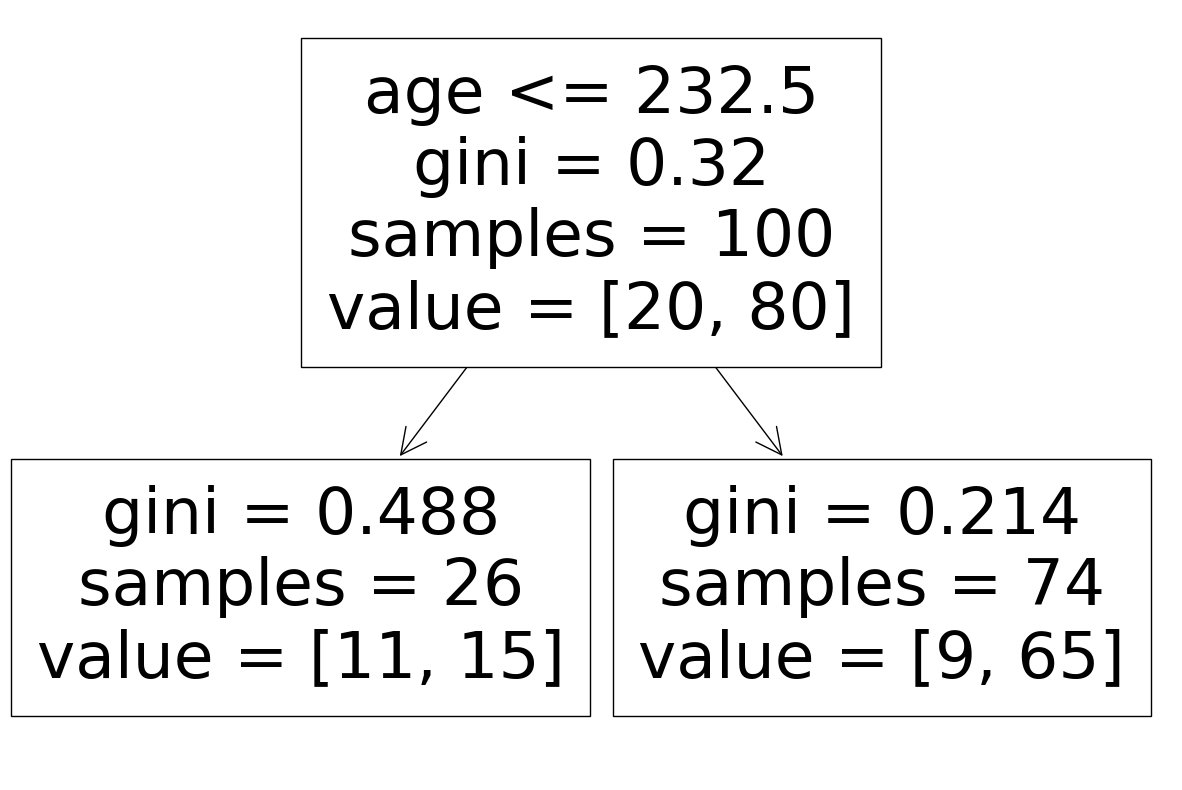

In [14]:
# see it again
dec_tree = train_dec_tree_gtky(df_gtky, max_depth=1, plot=True)

Notice that Gini score can go up for some samples (observe `.488 > .32` from root to left node) but it is always reduced on average:

In [22]:
mean_gini = 0.26 * 0.488 + 0.74*0.214
mean_gini

0.28524

Remember:

A feature & its associated threshold are chosen in a decision tree to minimize **the mean Gini Coefficient** of the output nodes. This means:
- no other feature at **any** other threshhold produces as low a **mean Gini** at the initial subset of the data
    - Think of it: if each feature has 100 observations, there are 101 ways to split each feature (101 possible thresholds for each feature). The decision tree tries each threshold for each feature, calculates the resulting mean Gini, then chooses the feature-threshold combination that produces the lowest mean Gini.

### Decision Tree Growth:
- Initialize a root which represents all samples
- Split samples of each leaf node until either
    - `max_depth` is reached
    - `gini=0` (all samples belong to a single class)
    
Notice that when `max_depth` is reached, there may be samples from multiple classes in a given node:
    
**A decision tree estimates as the most common class in a sample's resultant leaf**

### Python example interpretation:

Based on the below tree,
- a new student who is `age`=240 months old, reports their overall `prog_exp`=7, and has not learned `java`=False would be predicted to have `python` experience, because their resulting node has `[0,16] = [False, True]`.
- a new student who is `age`=230 months old, says their ideal `start_sal` = 75, and knows some `other(s)`=True programming language would be predicted to *not* have `python` experience, because their resulting node has `[4,2] = [False, True]`.

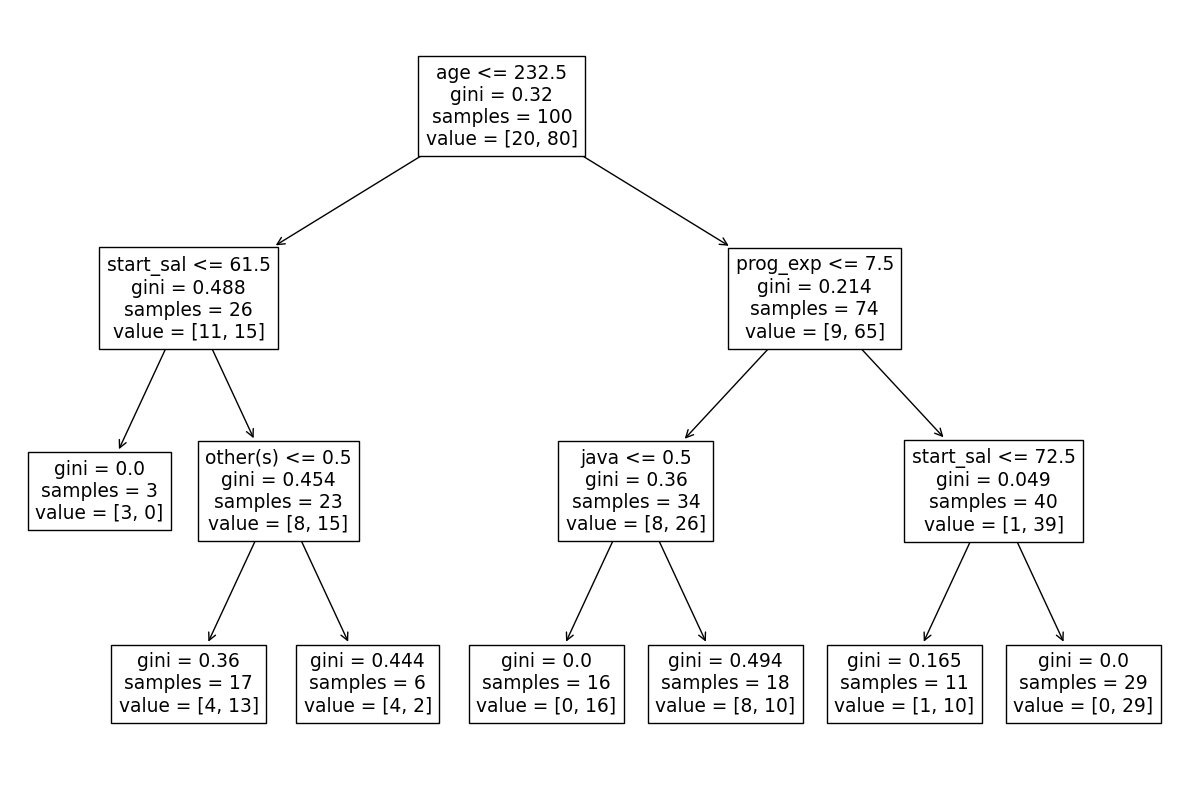

In [28]:
dec_tree = train_dec_tree_gtky(df_gtky, max_depth = 3, plot = True)

### Question: Why haven't we scaled the x-features as we did with K-NN for the decision tree?

## Let's try it with multiple classes with our penguin data set

1. Train and display a decision tree with `max_depth=3` which classifies the `species` of a penguin via the four numeric features in the data
1. Classify the following penguin by manually following their path through the tree:
    - body_mass_g = 4000
    - flipper_length_mm = 200
    - bill_depth_mm = 17
    - bill_length_mm = 45
1. Build a confusion matrix which shows how this decision tree performs in classifying "new" samples (cross validate).
1. Compute the overall accuracy of the decision tree classifier.
1. What happens if we set `max_depth=None` so that the tree continues building nodes until leaf nodes contain only a single class of samples (i.e. Gini score of each leaf is 0).  Critique this decision tree, is it appropriate to use on some new, unseen sample?

C:\Users\yangx\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\yangx\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\yangx\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\yangx\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

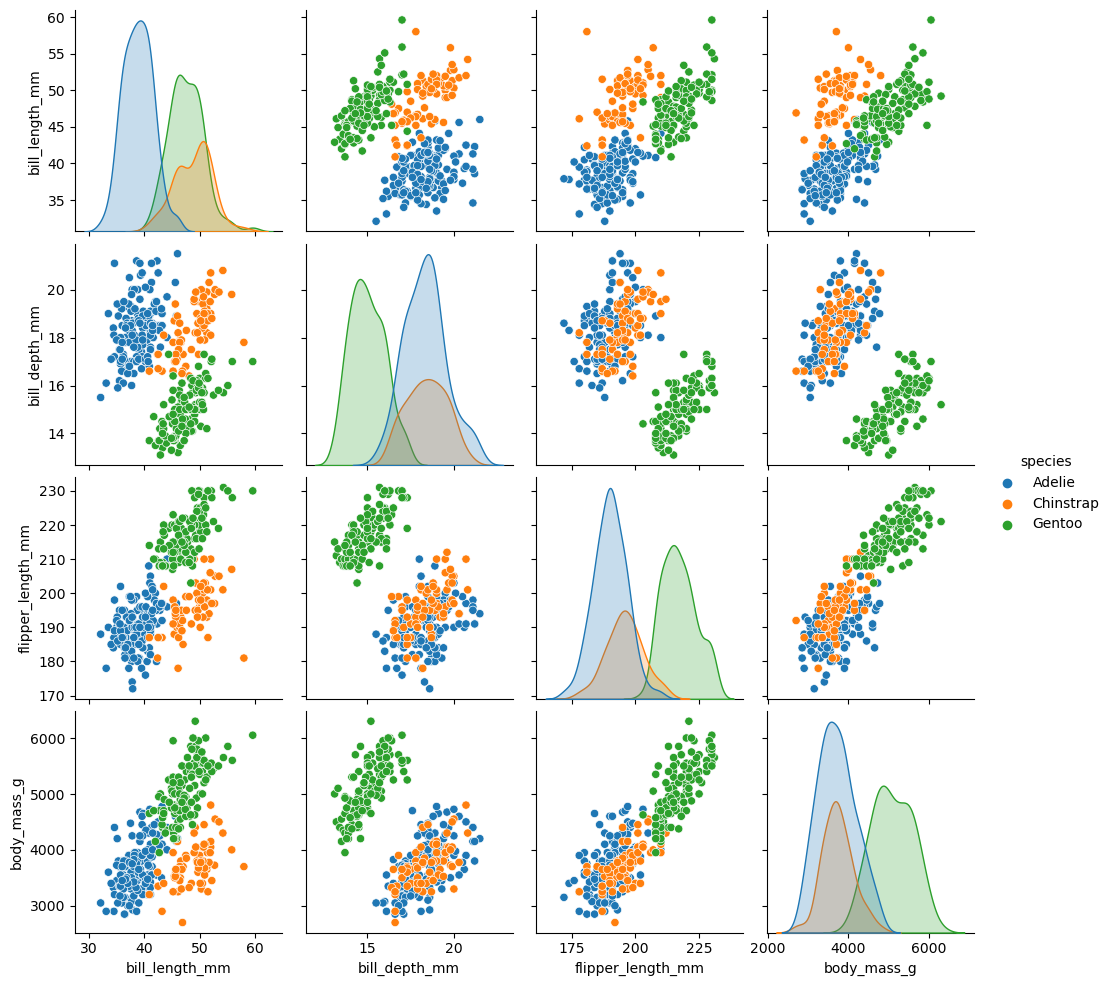

In [29]:
import pandas as pd
import seaborn as sns

df_penguin = sns.load_dataset('penguins')

df_penguin.dropna(axis=0, inplace=True)

sns.pairplot(df_penguin, hue='species')

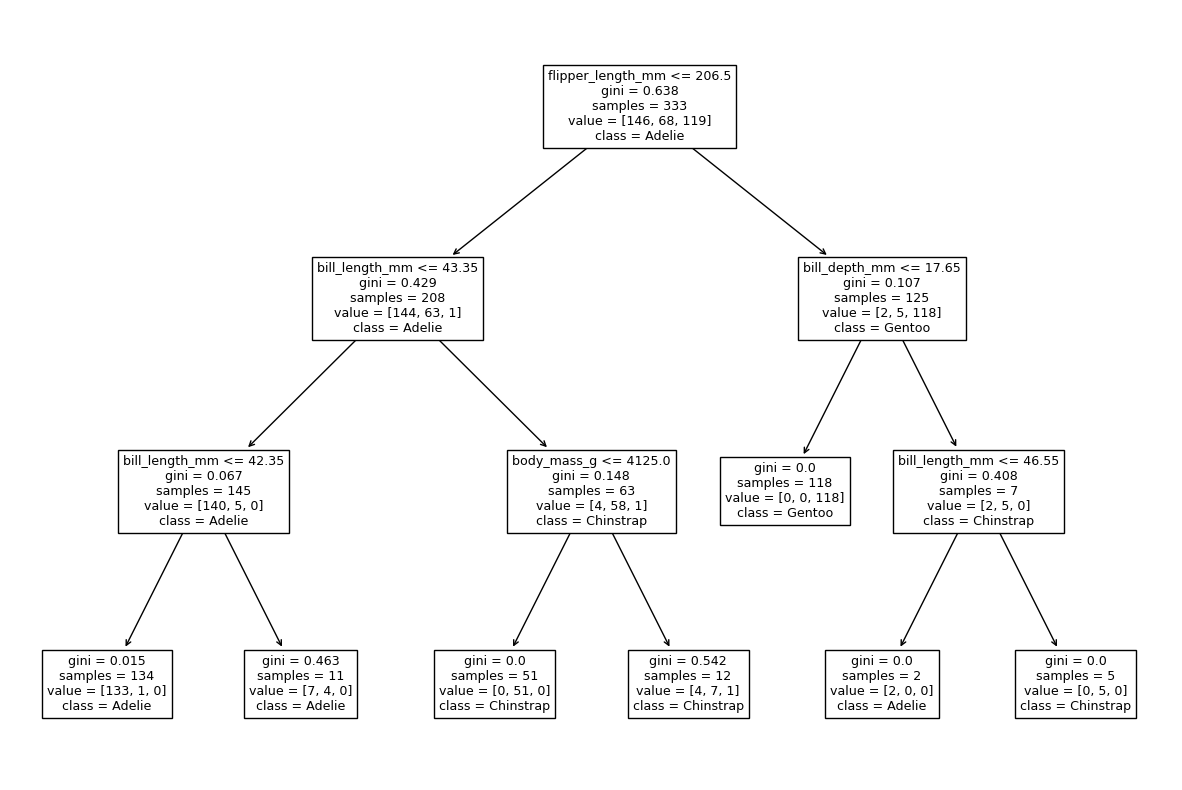

In [36]:
from sklearn import tree

max_depth = 3
x_feat_list = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

x = df_penguin.loc[:, x_feat_list].values
y = df_penguin.loc[:, 'species'].values

dec_tree_clf = tree.DecisionTreeClassifier(max_depth = max_depth)

dec_tree_clf.fit(x,y)

plt.figure()
plt.gcf().set_size_inches(15,10)

tree.plot_tree(dec_tree_clf, 
              feature_names = x_feat_list, 
               class_names = dec_tree_clf.classes_);

- body_mass_g = 4000
- flipper_length_mm = 200
- bill_depth_mm = 17
- bill_length_mm = 45

----------------------

- since flipper_length_mm <= 206.5 (yes) we move left
- since bill_length_mm > 43.35     (no)  we move right
- since body_mass_g <= 4125        (yes) we move left

we estimate as the penguin to be Chinstrap.

In [37]:
array_gerald = np.array([45,17,200,4000]).reshape(1,4)
dec_tree_clf.predict(array_gerald)

array(['Chinstrap'], dtype=object)

## Cross validation and confusion matrix for decision trees

Works exactly as it did for K-NN!

In [39]:
from sklearn.model_selection import StratifiedKFold

n_splits = 10 # 10-fold cross-validation
max_depth = 3

kfold = StratifiedKFold(n_splits = n_splits)

dec_tree_clf = tree.DecisionTreeClassifier(max_depth = max_depth)

y_pred = np.empty_like(y)

for train_idx, test_idx in kfold.split(x, y): 
    x_train = x[train_idx,:]
    y_train = y[train_idx]

    x_test = x[test_idx,:]

    dec_tree_clf.fit(x_train, y_train)
    y_pred[test_idx] = dec_tree_clf.predict(x_test)

[[139   6   1]
 [  8  60   0]
 [  1   1 117]]


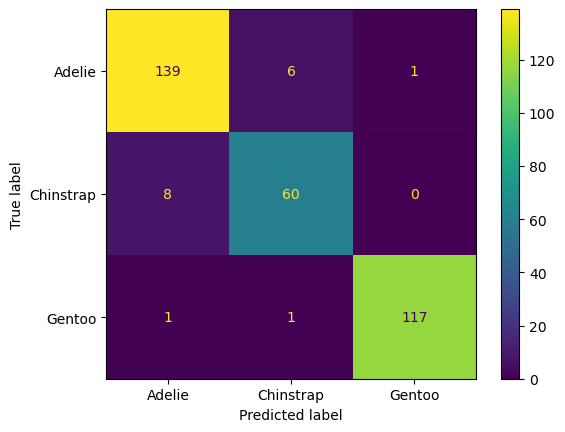

In [43]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

conf_matrix = confusion_matrix(y_true = y, y_pred = y_pred)
print(conf_matrix)

ConfusionMatrixDisplay(conf_matrix, display_labels = np.unique(y)).plot()

In [44]:
from sklearn.metrics import accuracy_score

accuracy_score(y, y_pred)

0.948948948948949

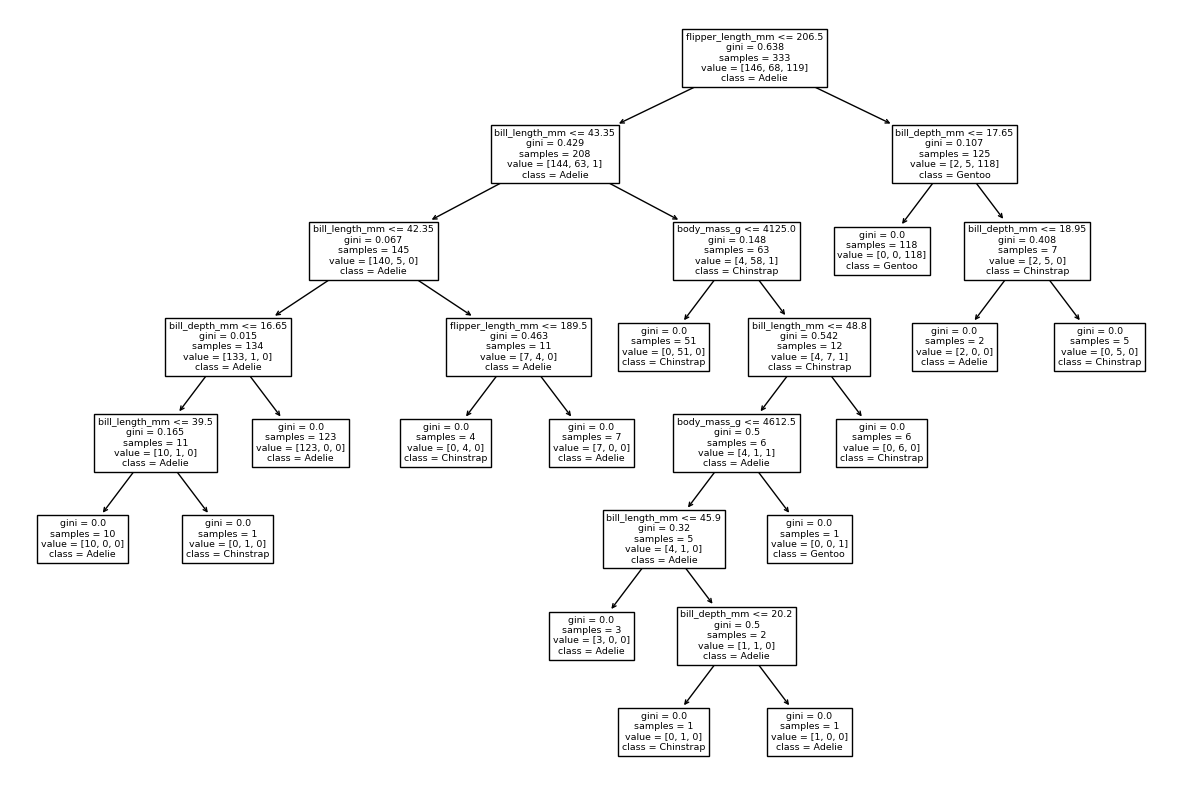

In [48]:
from matplotlib.backends.backend_pdf import PdfPages

f_out = 'penguin_dec_tree_overfit.pdf'

max_depth = None
x_feat_list = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

x = df_penguin.loc[:, x_feat_list].values
y = df_penguin.loc[:, 'species'].values

dec_tree_clf = tree.DecisionTreeClassifier(max_depth = max_depth)

dec_tree_clf.fit(x,y)

plt.figure()
plt.gcf().set_size_inches(15,10)

tree.plot_tree(dec_tree_clf, 
              feature_names = x_feat_list, 
               class_names = dec_tree_clf.classes_);

with PdfPages(f_out) as pdf:
    pdf.savefig(plt.gcf())

### Tree size: large or small

Small tree:
- small number of max depth
- small number of leaves
- more likely to have impure leaf
- underfit (large gini)
- small plot, easy to display and understand

Large tree: 
- large number of max_depth
- large number of leaves
- all the leaves have gini = 0
- overfit
- large plot, hard to display and understand

Solution: pruning
- Build a large tree (set the max_depth = 0)
- Use the cross-validation to decide where to cut the tree

### Tree can also be used for the regression case!

If your target value is numerical, you still can use the tree. 
We called it regression tree (to comtrast with decision tree/classification tree)

In the classification, the estimated class is the majority for the samples in the node
In the regression, the estimated value is the average for the samples in the node

In the regression, the only metrics we use for building or evaluating the tree is just the MSE. 

## Random Forests

What is the issue with the above decision tree? **Overfitting**. Formally, overfitting is when the resulting algorithm corresponds too closely or exactly to a particular set of data, and may therefore fail to fit to additional data or predict future observations reliably. Many of the terminal nodes have only a single penguin in them; it is perhaps a bit naive to think that future penguins with similar characteristics should be predicted as a species based on a single penguin.

## Random Forests: Why?

#### Random Forest Motivation: Less Overfitting
- because random forests utilize a bootstrapping approach (see below) where some samples are not used to construct parts of the forest, we can avoid the overfitting of a single decision tree

#### Random Forest Motivation: Variable Importance
- we also want to quantify how important each of the features is to succesful classification
- which feature describe why ... (taken from previous class projects)
	- a person defaults on their loan?
	- a person gets hired for a job?
	- one startup succeeds / fails
	- a college basketball player suceeds / fails when in nba
	- an internet article is classified as fake news

## Random Forest: Method

### Approach
1. Build a bunch of different decision trees
    - each uses a different set of training data (see Bagging below)
        - if they each used full dataset they'd all be the same ...
    - each node is restricted to use only some subset of features
        - for $n$ features, typically $\sqrt{n}$ of features are available to a given node
1. estimate as the majority classification among all the trees

### Approach Motivation
Why does this help?
- **Variable Importance** - how much, in a typical tree, does a feature lower Gini?
- **Overfitting** - since we aggregate over many different trees, we are allowing there to be *noise*

### How does a Random Forest build different sets of training data?
#### (this isn't quite the same as K-Fold Cross Validation)

**B**ootstrap **Agg**regation (**Bagg**ing)
- build a training set by resampling from a set of samples **with** replacement
    - this training set is called a "bag" of samples 
        - bags may have repeated samples
    - by convention, we don't call this training set a "fold" 
        - folds may not have repeated samples

In [49]:
import pandas as pd

# nonsense data
df = pd.DataFrame({'feat0': [1, 24, 8, 287], 
                  'feat1': [4, 6, 23, 985]},
             index=['sample_a', 'sample_b', 'sample_c', 'sample_d'])
df

,feat0,feat1
sample_a,1,4
sample_b,24,6
sample_c,8,23
sample_d,287,985


In [54]:
# bootstrap 
df.sample(5, replace = True)

,feat0,feat1
sample_b,24,6
sample_c,8,23
sample_c,8,23
sample_b,24,6
sample_b,24,6


## Random Forest Motivation: Measuring Feature Importance

According to the scikit-learn documentation: 
 >The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance.
 
In other words, a features importance is a ratio of:

    feat_import = total gini reduced (across all nodes of all trees in forest) due to one feature
                  ________________________________________________________________________________
                  total gini reduced (across all nodes of all trees in forest) due to all features

In [55]:
# read in the final, clean data set (reset so we no longer have the standardized columns)
df_gtky = pd.read_csv('final_gtky.csv', index_col='student_id')
df_gtky.dropna(how='any', inplace=True)
df_gtky.head()

# we can represent a binary categorical variable in a single indicator tag (as in our co-op example)
# let's do that with sophomores, juniors, and seniors (5th years and others we'll leave alone)
df_gtky['is_sop'] = df_gtky['class'] == 'Sophomore'
df_gtky['is_jun'] = df_gtky['class'] == 'Junior'
df_gtky['is_sen'] = df_gtky['class'] == 'Senior'

# discard any rows missing data
df_gtky.dropna(axis=0, inplace=True)

df_gtky.head()

,class,co-op,prog_exp,age,start_sal,datetimestamp,python,java,r,c/c++,other(s),is_sop,is_jun,is_sen
student_id,,,,,,,,,,,,,,
740492,Sophomore,False,9,234.0,60.0,2022-09-09 15:37:00,True,False,False,False,True,True,False,False
20d026,Sophomore,False,7,233.0,100.0,2022-09-09 16:01:00,True,False,False,False,False,True,False,False
e7fc49,Junior,True,7,252.0,70.0,2022-09-09 14:19:00,True,True,False,True,False,False,True,False
a49897,Junior,False,7,243.0,50.0,2022-09-09 16:07:00,True,True,False,False,False,False,True,False
425374,Sophomore,False,5,231.0,90.0,2022-09-09 16:06:00,True,False,True,False,False,True,False,False


In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

max_depth = 3

x_feat_list = ['co-op', 'prog_exp', 'age', 'start_sal', 'java', 'r', 'c/c++',
               'other(s)', 'is_sop', 'is_jun', 'is_sen']

x = df_gtky.loc[:,x_feat_list].values
y = df_gtky.loc[:, 'python'].values

rf_clf = RandomForestClassifier(max_depth = max_depth, n_estimators = 500)
rf_clf.fit(x,y)
y_pred = rf_clf.predict(x)

In [63]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true = y, y_pred = y_pred)

array([[ 2, 18],
       [ 0, 80]], dtype=int64)

<BarContainer object of 11 artists>

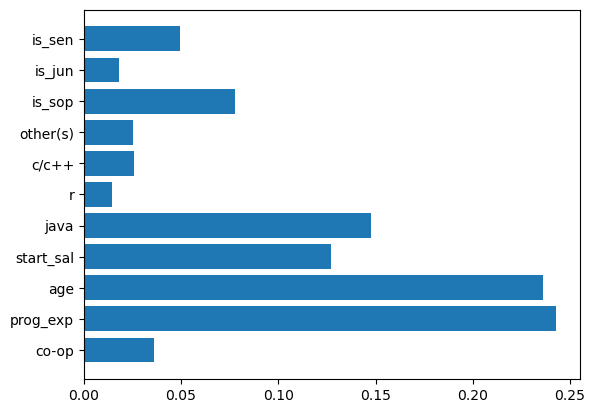

In [65]:
plt.barh(x_feat_list, rf_clf.feature_importances_)

In [77]:
def plot_feat_import(feat_list, feat_import, sort=True, limit=None):
    """ plots feature importances in a horizontal bar chart
    
    Args:
        feat_list (list): str names of features
        feat_import (np.array): feature importances (mean gini reduce)
        sort (bool): if True, sorts features in decreasing importance
            from top to bottom of plot
        limit (int): if passed, limits the number of features shown
            to this value    
    """
    
    if sort:
        # sort features in decreasing importance
        idx = np.argsort(feat_import).astype(int)
        feat_list = [feat_list[_idx] for _idx in idx]
        feat_import = feat_import[idx] 
        
    if limit is not None:
        # limit to the first limit feature
        feat_list = feat_list[-limit:]
        feat_import = feat_import[-limit:]
    
    # plot and label feature importance
    plt.barh(feat_list, feat_import)
    plt.gcf().set_size_inches(5, len(feat_list) / 2)
    plt.xlabel('Feature importance\n(Mean decrease in Gini across all Decision Trees)')

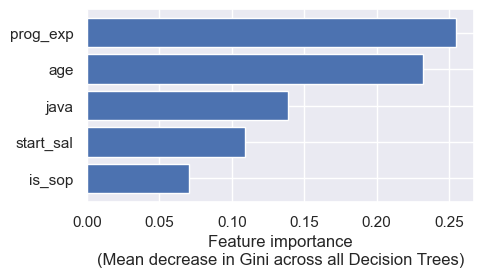

In [78]:
import numpy as np
import seaborn as sns

sns.set()

plot_feat_import(x_feat_list, rf_clf.feature_importances_, limit = 5)

Note that no direction is implied by a feature's importance:

`prog_exp` being high on this doesn't imply having more (or less) progreamming experience produces better chances at knowing python.  It could be that there are some `prog_exp` ranges which make it more likely (such as `prog_exp` being between 5-8 being more (or less) likely to produce a student with python experience) ... decision trees can re-use a feature in multiple nodes; all this tells us is that `prog_exp` was the most important feature for determining if a student has any python experience. 

## Nobody cares which features are important in a classifier that doesn't work ...
Before showing a plot / analysis like this, provide a confusion matrix which demonstrates that the classifier works, and doing it (as always) via cross validation is important:

In [71]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from sklearn import tree
import seaborn as sns

n_splits = 10
max_depth = 3
kfold = StratifiedKFold(n_splits = n_splits)

rf_clf = RandomForestClassifier(max_depth = max_depth, n_estimators = 500)

y_pred = np.empty_like(y)

for train_idx, test_idx in kfold.split(x,y):
    x_train = x[train_idx,:]
    y_train = y[train_idx]
    x_test = x[test_idx,:]

    rf_clf.fit(x_train, y_train)
    y_pred[test_idx] = rf_clf.predict(x_test)


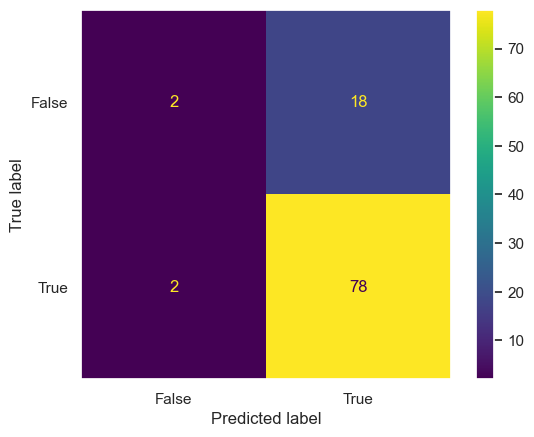

In [73]:
y_feat_list = np.array(['False', "True"])

conf_matrix = confusion_matrix(y_true = y, y_pred = y_pred)
conf_mat_disp = ConfusionMatrixDisplay(conf_matrix, display_labels = y_feat_list)
conf_mat_disp.plot()
plt.grid(False)

So, our Random Forest classifier does a **great** job of correctly identifying students who have programming experience, but a **terrible** job of identifying those who don't. This is **not** a good classifier, because while the accuracy and sensitivity are high, the specificity is very low.

In [74]:
def get_acc_sens_spec(y_true, y_pred, verbose=True):
    """ computes sensitivity & specificity (assumed binary inputs)

    Args:
        y_true (np.array): binary ground truth per trial
        y_pred (np.array): binary prediction per trial

    Returns:
        acc (float): accuracy
        sens (float): sensitivity
        spec (float): specificity
    """
    # line below stolen from sklearn confusion_matrix documentation
    tn, fp, fn, tp = confusion_matrix(y_true.astype(bool),
                                      y_pred.astype(bool),
                                      labels=(0, 1)).ravel()

    # compute sensitivity
    if tp + fn:
        sens = tp / (tp + fn)
    else:
        sens = np.nan

    # compute specificity
    if tn + fp:
        spec = tn / (tn + fp)
    else:
        spec = np.nan
        
    # compute acc
    acc = (tp + tn) / (tn + fp + fn + tp)

    return acc, sens, spec

In [75]:
get_acc_sens_spec(y, y_pred)

(0.8, 0.975, 0.1)

## Why not just compute Gini reduction on a single decision tree?
Given a single decision tree, we can quantify a feature's importance as the reduction in Gini produced across all the nodes which utilize this feature.  That should work, right?

What if two features are correlated?  A feature's importance can be "split" between some other correlated features.
- Example: What does it take to succeed in professional basketball?
    - height
    - weight
    - shoe size
    - hand span
    - hours spent playing basketball as a child
    
Random Forests, a variety of different trees can provide insight into how each feature helps classification performance by itself.  Now we can see why we had such a counter-intuitive construction of a Random Forest:

Each tree in a Random Forest has limited access to:
- samples
    - some samples may be withheld from each tree's training by sampling
- features
    - we restrict a random forest to choose from a random subset of features in each node

## Lecture Break/Practice

1. Build a Random Forest Classifier which classifies whether a potential speed dater will find a match or not. Use `max_depth = 4` and 10-fold cross validation.
1. Print a confusion matrix which estimates how well the classifier performs on new speed daters.  Qualitatively describe if your classifier is a useful tool to a non-technical expert.
    - If we're estimating performance on new samples we must cross validate (see above)
1. Print a bar plot (`plot_feat_import()`) to describe which features are most useful for classification.  Qualitatively describe if these most important features are meaningful. In other words:
    - If the classifier performs well, we care about which features helped it work
    - If the classifier doesn't perform well, we don't care which features helped it "work"

In [76]:
# these data were taken and cleaned from: 
# https://www.kaggle.com/datasets/whenamancodes/speed-dating?select=Speed+Dating+Data.csv
df_speeddat = pd.read_csv('Speed Dating Data.csv')
df_speeddat.dropna(how='any', inplace=True)
df_speeddat.head()

,gender,match,samerace,age_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,...,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga
0,0,0,0,27.0,35.0,20.0,20.0,20.0,0.0,5.0,...,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0
1,0,0,0,22.0,60.0,0.0,0.0,40.0,0.0,0.0,...,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0
2,0,1,1,22.0,19.0,18.0,19.0,18.0,14.0,12.0,...,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0
3,0,1,0,23.0,30.0,5.0,15.0,40.0,5.0,5.0,...,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0
4,0,1,0,24.0,30.0,10.0,20.0,10.0,10.0,20.0,...,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0


Our target feature (y) is:
- `match`: whether the speed date resulted in another date `0=no match` and `1=yes match`
    
The input feature list (x) includes:
- `gender`: the self-identified gender, in these data there are only `0=male` and `1=female` and there is no information on the gender of the partner
- `samerace`: if the speed dater is the same race as their parter (`0=no` and `1=yes`)
- `age_o`: age of the partner
- `pf_o_att` through `pf_o_sha`: the partner's rating of importance for qualities (attractiveness, sincerity, intelligence, funny, ambition, shared intrest)
- `attr_o` through `shar_o`: the partner's rating of the **speed dater** in each quality
- `age`: the age of the speed dater
- `sports` through `yoga`: the speed dater's level of interest in each activity

In [36]:
df_speeddat.columns

Index(['gender', 'match', 'samerace', 'age_o', 'pf_o_att', 'pf_o_sin',
       'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha', 'attr_o', 'sinc_o',
       'intel_o', 'fun_o', 'amb_o', 'shar_o', 'age', 'sports', 'tvsports',
       'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing',
       'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping',
       'yoga'],
      dtype='object')

In [79]:
x_feat_list = list(df_speeddat.columns)

x = df_speeddat.loc[:, x_feat_list].values
y = df_speeddat.loc[:, 'match'].values

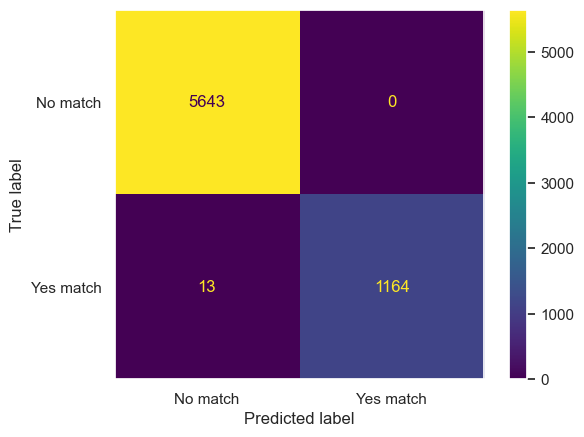

In [80]:
n_splits = 10
max_depth = 4

kfold = StratifiedKFold(n_splits = n_splits)
rf_clf = RandomForestClassifier(max_depth = max_depth, n_estimators = 1000)
y_pred = np.empty_like(y)

for train_idx, test_idx in kfold.split(x,y):
    x_train = x[train_idx,:]
    x_test = x[test_idx,:]
    y_train = y[train_idx]

    rf_clf.fit(x_train, y_train)
    y_pred[test_idx] = rf_clf.predict(x_test)

y_feat_list = np.array(['No match', 'Yes match'])

conf_mat = confusion_matrix(y_true = y, y_pred = y_pred)
ConfusionMatrixDisplay(conf_mat, display_labels = y_feat_list).plot()
plt.grid(False)

In [81]:
get_acc_sens_spec(y, y_pred)

(0.9980938416422287, 0.9889549702633815, 1.0)

#### Is this useful?


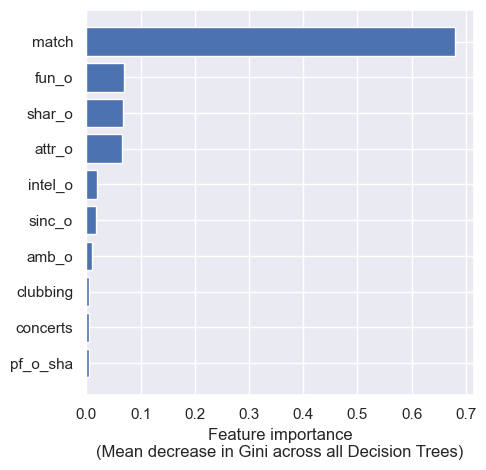

In [82]:
plot_feat_import(x_feat_list, rf_clf.feature_importances_, limit = 10)

### Extra exercise

In [83]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
X = pd.DataFrame(data.data, columns = data.feature_names)
y = data.target

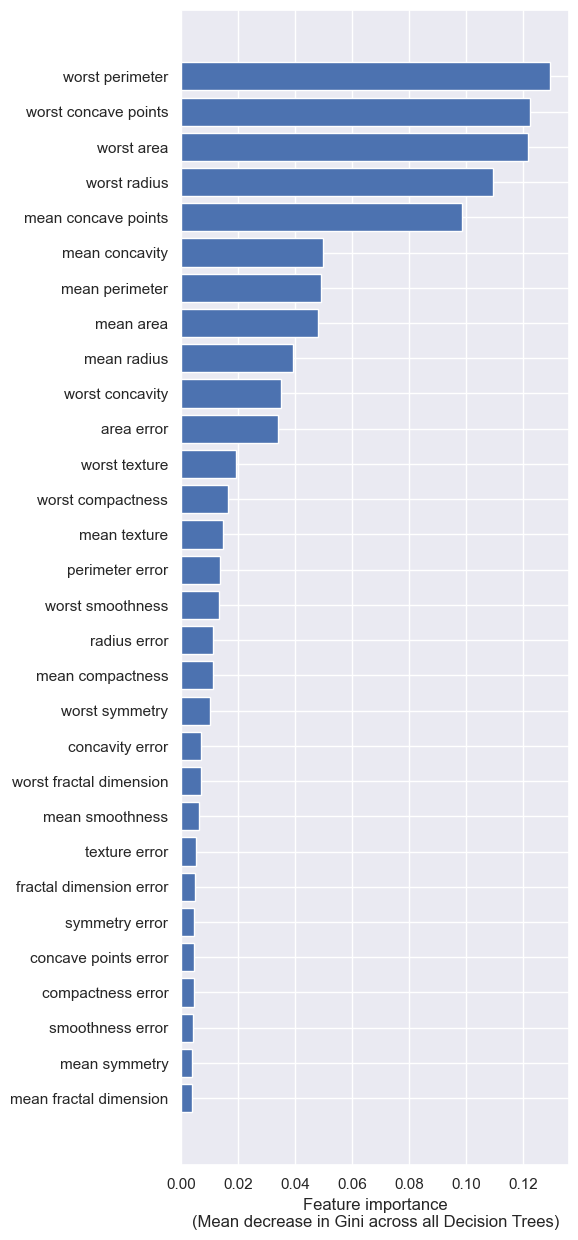

In [86]:
# If I decide to use random forest as a pre-processing step

rf_clf = RandomForestClassifier(max_depth = None, n_estimators = 1000, random_state = 1)
rf_clf.fit(X,y)

x_feat_list = data.feature_names
plot_feat_import(x_feat_list, rf_clf.feature_importances_, limit = None)

In [89]:
# option 1: tune the parameter

from sklearn.model_selection import train_test_split, GridSearchCV

idx = np.argsort(rf_clf.feature_importances_).astype(int)
feat_list = [x_feat_list[_idx] for _idx in idx]
new_feat_list = feat_list[-11:]
X_new = X.loc[:, new_feat_list]

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.2, random_state = 1)

rf = RandomForestClassifier(random_state = 1)

param_grid = {
    'n_estimators':[50, 100, 150],
    'max_depth': [None, 5, 10],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, n_jobs = -1, 
                           scoring = 'accuracy', verbose = 1)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy', verbose=1)

In [90]:
grid_search.best_params_

{'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 50}

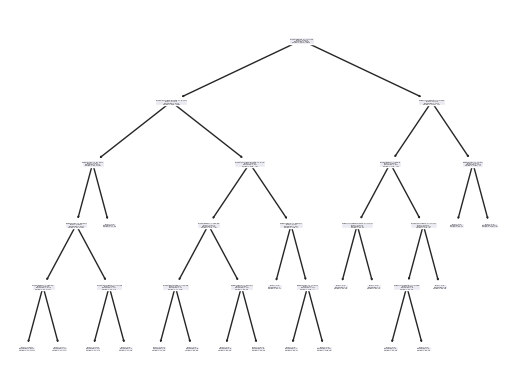

In [88]:
# option 2: 

from sklearn import tree
max_depth = 5

idx = np.argsort(rf_clf.feature_importances_).astype(int)
feat_list = [x_feat_list[_idx] for _idx in idx]
new_feat_list = feat_list[-11:]
X_new = X.loc[:, new_feat_list]

dec_tree_clf = tree.DecisionTreeClassifier(max_depth = max_depth)
dec_tree_clf.fit(X_new,y)

plt.figure()
tree.plot_tree(dec_tree_clf, feature_names = new_feat_list);